In [1]:
import numpy as np
import pandas as pd
from itertools import chain

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping

np.random.seed(42)
plt.rc('axes', labelsize='larger')

In [2]:
digits = load_digits()
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [3]:
X = pd.DataFrame(digits.data)
y = pd.Series(digits.target)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, stratify=y)

In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
%%time
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=[X_train.shape[1]]))
model.add(Dropout(.3))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(.3))
model.add(BatchNormalization())
model.add(Dense(y.nunique(), activation='softmax'))

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='accuracy',
    min_delta=.001,
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    batch_size=100,
    epochs=500,
    callbacks=[early_stopping],
    verbose=0
)

Wall time: 3.78 s


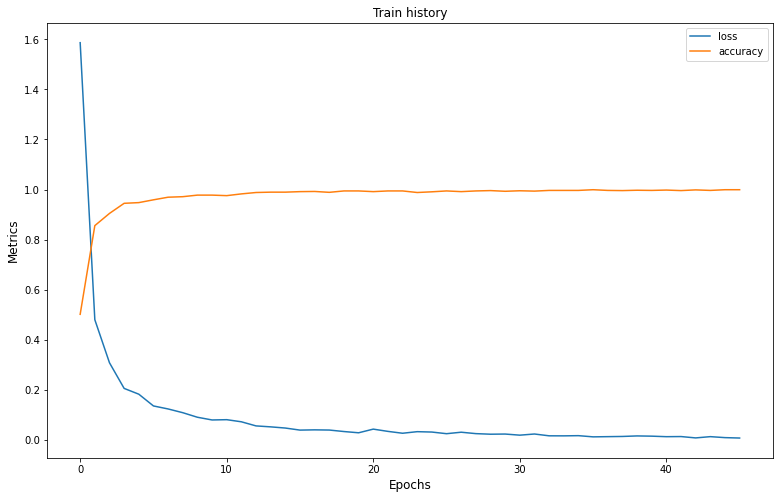

In [7]:
pd.DataFrame(history.history).plot(figsize=(13,8))
plt.title('Train history')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.show()

In [8]:
y_pred = model.predict(X_test)
y_pred = np.array([np.argmax(pred) for pred in y_pred])

In [9]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.95      0.97      0.96        36
           2       0.97      1.00      0.99        35
           3       0.97      1.00      0.99        37
           4       1.00      0.97      0.99        36
           5       1.00      1.00      1.00        37
           6       1.00      0.97      0.99        36
           7       1.00      1.00      1.00        36
           8       0.97      0.89      0.93        35
           9       0.95      1.00      0.97        36

    accuracy                           0.98       360
   macro avg       0.98      0.98      0.98       360
weighted avg       0.98      0.98      0.98       360



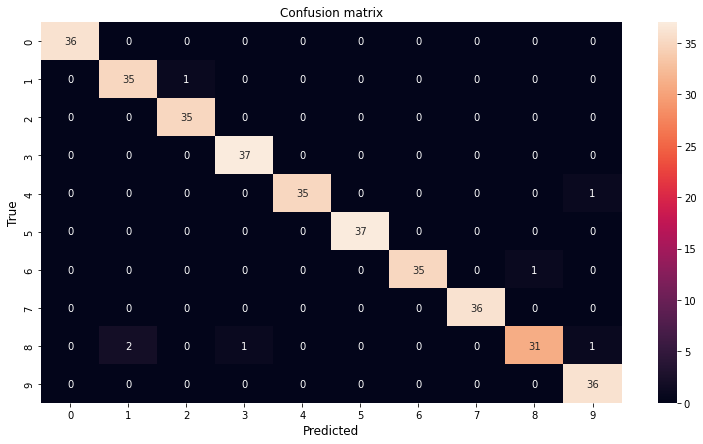

In [10]:
plt.figure(figsize=(13,7))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

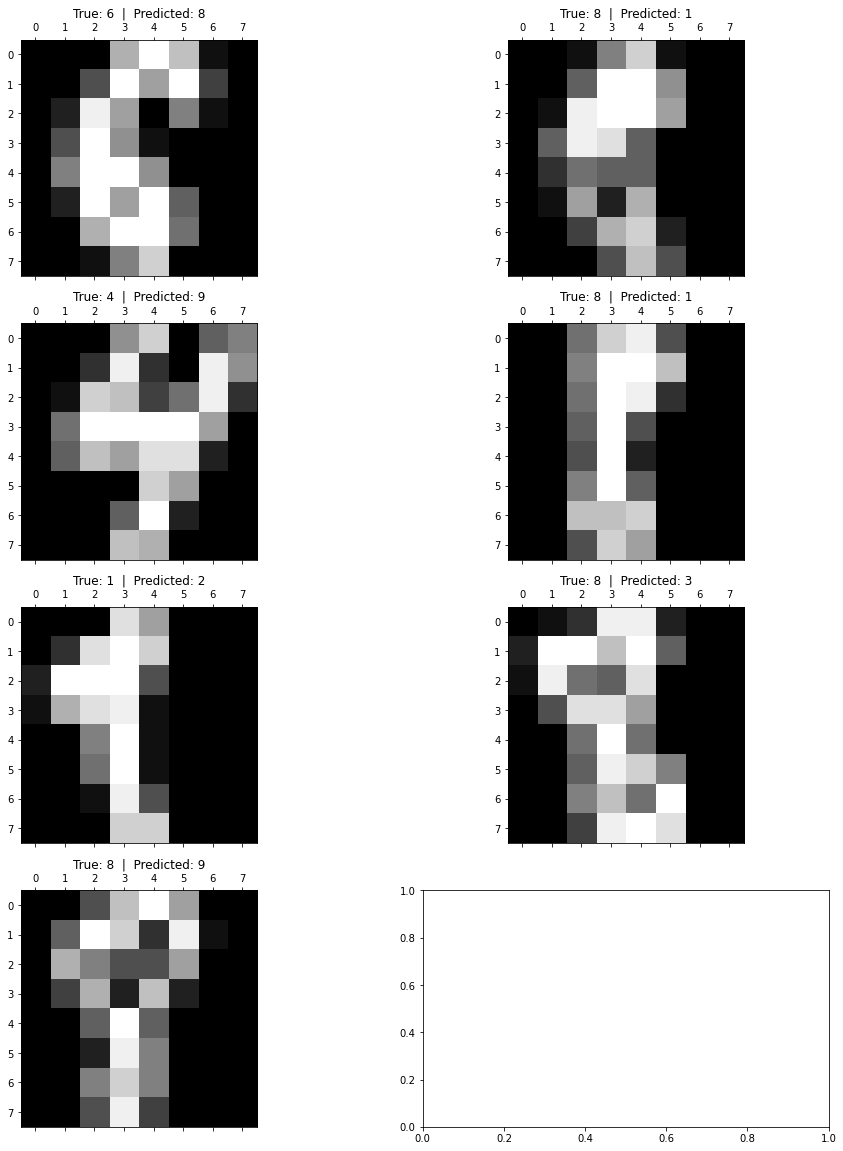

In [11]:
mask = ~(y_test.values == y_pred)
errors_true, errors_pred = y_test[mask], y_pred[mask]
errors_images = digits.images[errors_true.index]

fig, ax = plt.subplots(
    int(np.ceil(len(errors_true) / 2)), 2, 
    figsize=(16,20))
axes = list(chain.from_iterable(ax))

plt.gray()
for ix, label in enumerate(errors_true):
    axes[ix].matshow(errors_images[ix])
    axes[ix].set_title(f"True: {label}  |  Predicted: {errors_pred[ix]}")
plt.show()

can't blame the network for mispredicting those xd